# Molecular model

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import rdkit
from rdkit import Chem
from rdkit.Chem import rdchem
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F
from torch_geometric.nn import NNConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.data import DataLoader, Batch

# Load the dataset and calculate the molecular graph

In [49]:
# read CSV file
df = pd.read_csv('./Data/logP_labels.csv',index_col=0)

# split into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.111, random_state=42)

In [56]:
# define atom features
def get_atom_features(atom):
    return [
        atom.GetAtomicNum(),  # atomic number
        atom.GetMass(),       # atomic mass
        atom.GetIsAromatic(), # whether is aromatic
        atom.GetDegree(),     # valence
        atom.GetExplicitValence(), # explicit valence
        atom.GetHybridization(),   # hybridization
        atom.IsInRing()            # whether is in ring
    ]

# define bond features
def get_bond_features(bond):
    return [
        bond.GetBondType() == Chem.rdchem.BondType.SINGLE,   # whether is single bond
        bond.GetBondType() == Chem.rdchem.BondType.DOUBLE,   # whether is double bond
        bond.GetBondType() == Chem.rdchem.BondType.TRIPLE,   # whether is triple bond
        bond.GetBondType() == Chem.rdchem.BondType.AROMATIC, # whether is aromatic bond
        bond.GetIsConjugated(),    # whether is conjugated
        bond.GetStereo()          # Stereochemical type
    ]

# define a function to convert smiles to graphs
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    atoms = mol.GetAtoms()

    # node features
    node_features = torch.tensor([get_atom_features(atom) for atom in atoms], dtype=torch.float)

    # edge features
    edge_index, edge_attr = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))
        edge_attr.append(get_bond_features(bond))
        edge_attr.append(get_bond_features(bond))

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)


In [52]:
# save the graph dataset
def create_and_save_graph_dataset(df, filename):
    graph_dataset = []
    graph_data = {}
    for smiles, logP in df.itertuples(index=False):
        graph_data= smiles_to_graph(smiles)
        graph_data.y = torch.tensor([logP], dtype=torch.float)
        graph_dataset.append(graph_data)

    torch.save(graph_dataset, filename)

create_and_save_graph_dataset(train_df, './Data/train.pt')
create_and_save_graph_dataset(val_df, './Data/val.pt')
create_and_save_graph_dataset(test_df, './Data/test.pt')


# estabilish GNN model

In [2]:
class GNN(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(GNN, self).__init__()
        nn1 = Sequential(Linear(num_edge_features, 16), ReLU(), Linear(16, num_node_features * 16))
        nn2 = Sequential(Linear(num_edge_features, 16), ReLU(), Linear(16, 16 * 32))

        self.conv1 = NNConv(num_node_features, 16, nn1, aggr='mean')
        self.conv2 = NNConv(16, 32, nn2, aggr='mean')
        self.fc = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_dataset = torch.load('./Data/train.pt')
val_dataset = torch.load('./Data/val.pt')
test_dataset = torch.load('./Data/test.pt')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Using device: cuda


In [18]:
num_epochs=100
num_node_features=7
num_edge_features=6

model = GNN(num_node_features, num_edge_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses=[]
val_losses = []
val_r2_scores = []
# train the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch).squeeze()
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader.dataset))
    print(f'Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset)}')


    model.eval()
    val_loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in val_loader:
            data.to(device)
            output = model(data).squeeze()
            val_loss += F.mse_loss(output, data.y)
            y_true.extend(data.y.tolist())
            y_pred.extend(output.tolist())
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_r2_scores.append(r2_score(y_true, y_pred))

Epoch 0, Loss: 0.08912928928911408
Epoch 1, Loss: 0.08115935068094333
Epoch 2, Loss: 0.07663915243721463
Epoch 3, Loss: 0.07275349815185503
Epoch 4, Loss: 0.06858162665091729
Epoch 5, Loss: 0.06539917110440256
Epoch 6, Loss: 0.06454256828389841
Epoch 7, Loss: 0.059797919234862856
Epoch 8, Loss: 0.05880438952458177
Epoch 9, Loss: 0.05499464083459997
Epoch 10, Loss: 0.05287729490792433
Epoch 11, Loss: 0.052843987589611514
Epoch 12, Loss: 0.048035374544735006
Epoch 13, Loss: 0.046880192625681334
Epoch 14, Loss: 0.04379893899668189
Epoch 15, Loss: 0.043871201232526365
Epoch 16, Loss: 0.041179463783696725
Epoch 17, Loss: 0.04057155736496961
Epoch 18, Loss: 0.03900826524704309
Epoch 19, Loss: 0.03891380606752131
Epoch 20, Loss: 0.03617038761021105
Epoch 21, Loss: 0.03671953167752208
Epoch 22, Loss: 0.035618419987679624
Epoch 23, Loss: 0.03531600612305783
Epoch 24, Loss: 0.03532791045720947
Epoch 25, Loss: 0.034582039220614175
Epoch 26, Loss: 0.03431969107684714
Epoch 27, Loss: 0.035350683985

# plot the training and validation losses and R2 scores

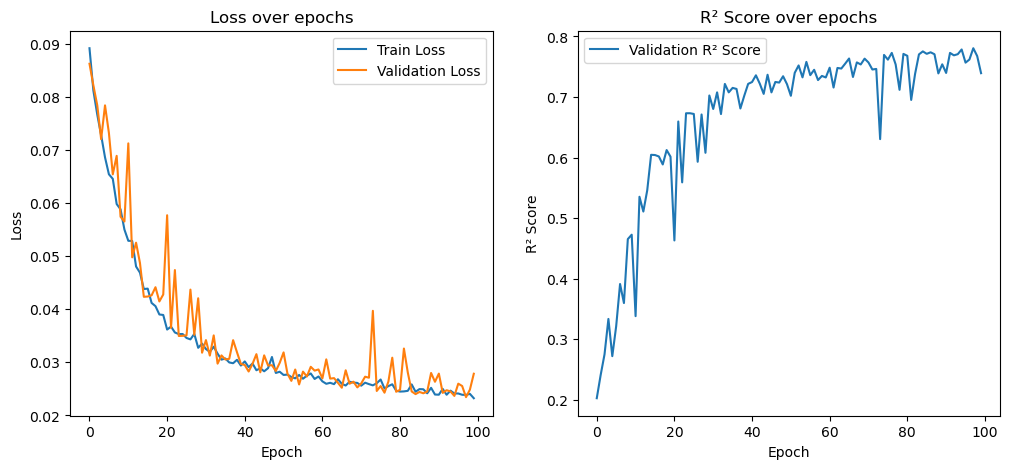

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label='Validation R² Score')
plt.title('R² Score over epochs')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()

plt.savefig('./Result/molecular_graph_train_loss.png')

# test the model in test set

R² on test set: 0.7506373896376156


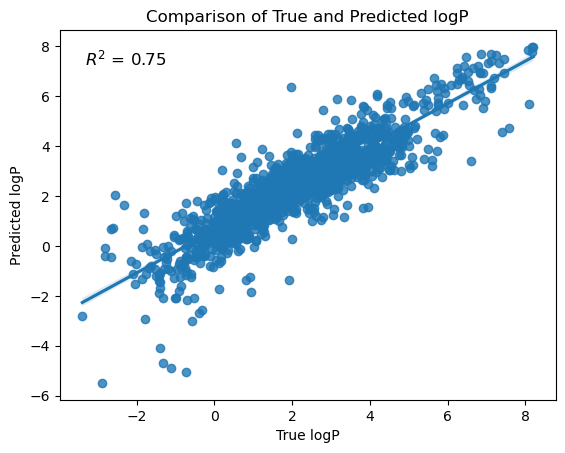

In [32]:
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for test_batch in test_loader:
        test_batch.to(device)
        test_pred = model(test_batch).squeeze()
        y_true.extend(test_batch.y.tolist())
        y_pred.extend(test_pred.tolist())

r2 = r2_score(y_true, y_pred)
print(f'R² on test set: {r2}')

sns.regplot(x=y_true, y=y_pred)
plt.text(0.05, 0.95, f'$R^2$ = {r2:.2f}', fontsize=12, va='top', transform=plt.gca().transAxes)
plt.xlabel('True logP')
plt.ylabel('Predicted logP')
plt.title('Comparison of True and Predicted logP')

plt.savefig('./Result/molecular_graph_test_r2.png')